In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https:// ### ADD GIT TOKEN ### y@github.com/mcembalest/teamBlueConduit.git
%cd teamBlueConduit
!pip install .
!pip install -r requirements.txt > /dev/null
%cd gizmo
!pip install -e .

Cloning into 'teamBlueConduit'...
remote: Enumerating objects: 761, done.
remote: Counting objects: 100% (761/761), done.
remote: Compressing objects: 100% (533/533), done.
remote: Total 761 (delta 375), reused 538 (delta 207), pack-reused 0
Receiving objects: 100% (761/761), 57.43 MiB | 8.09 MiB/s, done.
Resolving deltas: 100% (375/375), done.
/content/teamBlueConduit
Processing /content/teamBlueConduit
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for BlueConduitSpatial: filename=BlueConduitSpatial-0.0.0-py3-none-any.whl size=66694 sha256=fb69e07032266f4d5932c4b435aef453465565d884680908adfbf9f2e88eccc8
  Stored in directory:

#MAKE SURE TO RESTART KERNEL

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

import scipy
from scipy.sparse import csr_matrix

###########
# import our libraries
from blue_conduit_spatial.utilities import *
from blue_conduit_spatial.evaluation import *
from blue_conduit_spatial.distance_matrix import *

LAT_MIN, LAT_MAX = 42.97, 43.09
LON_MIN, LON_MAX = -83.75, -83.62

########### set random state
np.random.seed(297)

# load our data

In [ ]:
data_dir = '/content/drive/MyDrive/AC297r/Data'
load_dir = f'{data_dir}/Processed'
pred_dir = f'{data_dir}/Predictions'
pid_lat_lon_path = f'{load_dir}/pid.gpkg'
train_pred_path = f'{pred_dir}/pred_probs_train.npz'
test_pred_path = f'{pred_dir}/pred_probs_test.npz'

Xdata, Ydata, pid, train_idx, test_idx, partitions_builder = load_datasets(load_dir)
train_pred_all, test_pred_all = load_predictions(pred_dir)

In [ ]:
hex_size = 47
train_size = 0.1
split = 0

(train_index, test_index, 
 Xtrain, Xtest, Ytrain, Ytest, 
 train_pred, test_pred, hexagons) = select_data(Xdata, 
                                                Ydata, 
                                                pid, 
                                                train_idx, 
                                                test_idx, 
                                                train_pred_all, 
                                                test_pred_all,
                                                partitions_builder, 
                                                train_size=train_size,
                                                n_hexagons=hex_size,
                                                split=split)

2021-11-02 06:12.53 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 1138/1138 [00:00<00:00, 25559.41it/s]

2021-11-02 06:12.55 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-02 06:12.55 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-02 06:12.57 [debug    ] Total parcels after join: 26857
2021-11-02 06:12.57 [info     ] Building the connected graph on the partitions.
2021-11-02 06:13.00 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory


In [ ]:
Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape

((2354, 301), (19293, 301), (2354,), (19293,))

In [ ]:
# load distance data
# this part is slow
dis_path = f'{load_dir}/road_distances.npz'
distances = np.load(dis_path, allow_pickle=True)

graph = distances['road_distances']
graph[graph==(1.00e+05)]=0.0 #assign invalid 1e5 values to be 0

##Invert distances
invert = lambda x: 1 / (1 + x)
graph = invert(graph)
graph[graph==(1.0)]=0.0

print('graph', graph.shape)

graph (26857, 26857)


In [ ]:
N_total = len(Ydata)
lead_rate_full_data = np.mean(Ydata.dangerous.values)

print('True lead rate in city: ', lead_rate_full_data)

True lead rate in city:  0.3822094798376587


# Scale the data

In [ ]:
scaler = StandardScaler()
Xdata_scaled_train = scaler.fit_transform(Xdata.iloc[train_index])
Xdata_scaled_test = scaler.transform(Xdata.iloc[test_index])

Xdata_scaled = Xdata.copy()
Xdata_scaled.iloc[train_index] = Xdata_scaled_train
Xdata_scaled.iloc[test_index] = Xdata_scaled_test
Xdata_scaled

,Homestead Percent,HomeSEV,Land Value,Land Improvements Value,Residential Building Value,Commercial Building Value,Parcel Acres,Year Built,SL_Lead,Ed_July,Ed_March,Max_Lead,Med_Lead,Num_Tests,Res_Test,Sen_Test,B_median_age_all_women,B_median_age_all_men,B_median_age_all,B_median_age_all_women_white,B_median_age_all_men_white,B_median_age_all_white,B_median_age_all_women_black,B_median_age_all_men_black,B_median_age_all_black,B_total_black_pop,B_total_white_pop,B_married_couples,B_single_women,B_married_couples_white,B_single_women_white,B_married_couples_black,B_single_women_black,B_married_couples_w_children,B_single_mothers_w_children,B_households_w_elderly,B_househod_no_elderly,B_aggregate_income,B_speak_spanish,B_speak_only_english,...,CENTRACT_600,CENTRACT_700,CENTRACT_800,CENTRACT_900,CENTRACT_1000,CENTRACT_1100,CENTRACT_1200,CENTRACT_1300,CENTRACT_1400,CENTRACT_1500,CENTRACT_1600,CENTRACT_1700,CENTRACT_1800,CENTRACT_1900,CENTRACT_2000,CENTRACT_2200,CENTRACT_2300,CENTRACT_2400,CENTRACT_2600,CENTRACT_2700,CENTRACT_2800,CENTRACT_2900,CENTRACT_3000,CENTRACT_3100,CENTRACT_3200,CENTRACT_3300,CENTRACT_3400,CENTRACT_3500,CENTRACT_3600,CENTRACT_3700,CENTRACT_3800,CENTRACT_4000,CENTRACT_13500,CENTRACT_13600,CENBLOCK_1,CENBLOCK_2,CENBLOCK_3,CENBLOCK_4,CENBLOCK_5,CENBLOCK_6
0,0.398553,1.224099,-0.554546,-0.132839,-0.290141,-0.043008,-0.023841,-3.800170,-0.272755,-0.080081,-0.080081,-0.039726,-0.779736,-0.350296,-0.781104,-0.168513,-1.324648,-0.296246,-1.098771,0.232692,0.224647,-0.256367,-0.302082,0.668977,-0.585932,1.447928,-0.025916,0.01459,-0.200298,-0.952371,-0.979791,1.855925,0.695882,-0.389675,0.300235,-0.763148,1.389521,-0.207591,1.707996,1.321813,...,-0.035722,-0.252417,-0.101491,0.0,-0.090206,-0.167175,-0.221404,-0.197066,-0.167175,0.0,-0.226632,-0.065316,0.0,0.0,-0.121059,0.0,-0.201673,-0.128092,-0.165828,-0.139603,11.392005,-0.219284,-0.426294,-0.092569,-0.206193,0.0,0.0,-0.222457,-0.307205,-0.142733,-0.191175,-0.180156,-0.267322,0.0,-0.563941,1.395057,-0.543638,-0.42281,-0.202811,0.0
1,0.398553,0.507317,-0.599385,-0.132839,-0.560610,-0.043008,-1.101734,-3.800170,-0.272755,-0.080081,-0.080081,-0.039726,-0.779736,-0.350296,-0.781104,-0.168513,-1.324648,-0.296246,-1.098771,0.232692,0.224647,-0.256367,-0.302082,0.668977,-0.585932,1.447928,-0.025916,0.01459,-0.200298,-0.952371,-0.979791,1.855925,0.695882,-0.389675,0.300235,-0.763148,1.389521,-0.207591,1.707996,1.321813,...,-0.035722,-0.252417,-0.101491,0.0,-0.090206,-0.167175,-0.221404,-0.197066,-0.167175,0.0,-0.226632,-0.065316,0.0,0.0,-0.121059,0.0,-0.201673,-0.128092,-0.165828,-0.139603,11.392005,-0.219284,-0.426294,-0.092569,-0.206193,0.0,0.0,-0.222457,-0.307205,-0.142733,-0.191175,-0.180156,-0.267322,0.0,-0.563941,1.395057,-0.543638,-0.42281,-0.202811,0.0
2,-2.540192,-0.774203,-0.583446,-0.132839,-0.668811,-0.043008,-1.089758,0.199707,-0.272755,-0.080081,-0.080081,-0.039726,-0.779736,-0.350296,-0.781104,-0.168513,-1.324648,-0.296246,-1.098771,0.232692,0.224647,-0.256367,-0.302082,0.668977,-0.585932,1.447928,-0.025916,0.01459,-0.200298,-0.952371,-0.979791,1.855925,0.695882,-0.389675,0.300235,-0.763148,1.389521,-0.207591,1.707996,1.321813,...,-0.035722,-0.252417,-0.101491,0.0,-0.090206,-0.167175,-0.221404,-0.197066,-0.167175,0.0,-0.226632,-0.065316,0.0,0.0,-0.121059,0.0,-0.201673,-0.128092,-0.165828,-0.139603,11.392005,-0.219284,-0.426294,-0.092569,-0.206193,0.0,0.0,-0.222457,-0.307205,-0.142733,-0.191175,-0.180156,-0.267322,0.0,-0.563941,1.395057,-0.543638,-0.42281,-0.202811,0.0
3,-1.070820,-0.280058,-0.567770,-0.132839,-0.684418,-0.043008,-0.670577,-3.800170,-0.272755,-0.080081,-0.080081,-0.036121,1.255974,0.078512,1.280240,-0.168513,-1.324648,-0.296246,-1.098771,0.232692,0.224647,-0.256367,-0.302082,0.668977,-0.585932,1.447928,-0.025916,0.01459,-0.200298,-0.952371,-0.979791,1.855925,0.695882,-0.389675,0.300235,-0.763148,1.389521,-0.207591,1.707996,1.321813,...,-0.035722,-0.252417,-0.101491,0.0,-0.090206,-0.167175,-0.221404,-0.197066,-0.167175,0.0,-0.226632,-0.065316,0.

# data loaded

# build subgraph

In [ ]:
#n_subgraph = 2000
subgraph_idx = np.array([i for i in range(N_total) if (i in train_index or i in test_index)])
n_subgraph = len(subgraph_idx)
subgraph = graph[:,subgraph_idx][subgraph_idx,:]
print('subgraph', subgraph.shape, '\n', subgraph)

subgraph (21647, 21647) 
 [[0.         0.02096436 0.02087683 ... 0.         0.         0.        ]
 [0.02710027 0.         0.01398601 ... 0.         0.         0.        ]
 [0.02242152 0.01344086 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.03508772 0.02506266]
 [0.         0.         0.         ... 0.03968254 0.         0.03215434]
 [0.         0.         0.         ... 0.02314815 0.03215434 0.        ]]


# GNN code

In [ ]:
def masked_softmax_cross_entropy_loss(logits, labels, mask):
  loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
  mask = tf.cast(mask, dtype=tf.float32)
  mask /= tf.reduce_mean(mask)
  loss *= mask
  res = tf.reduce_mean(loss)
  #print('cross entropy: ', res)
  return tf.reduce_mean(loss)

def masked_accuracy(logits, labels, mask):
  correct_prediction = tf.equal(tf.argmax(logits, axis=1), tf.argmax(labels, axis=1))
  accuracy_all = tf.cast(correct_prediction, tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  mask /= tf.reduce_mean(mask)
  accuracy_all *= mask
  return tf.reduce_mean(accuracy_all)

# def contrastive_loss(logits, labels, mask):
#   """Calculates the constrastive loss.
#   Returns:
#       A tensor containing constrastive loss as floating point value.
#   """
#   y_true = labels[:,1]*mask
#   y_pred = logits*mask
#   square_pred = tf.math.square(y_pred)
#   margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
#   res = tf.math.reduce_mean(
#       (1 - y_true) * square_pred + (y_true) * margin_square
#   )
#   print('contrastive loss: ', res)
#   return res

def create_ffn(hidden_units, dropout_rate, name=None):
  # helper function to create a feed-forward dense network with BatchNorm, Dropout, Dense, and GeLU activation
  
    fnn_layers = []
    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))
    return keras.Sequential(fnn_layers, name=name)

class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        # if weights is not None:
        #     print(messages.shape, tf.expand_dims(weights, -1).shape)
        #     messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gated":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

class GNN(tf.keras.Model):
  def __init__(self, sparse_edges, sparse_edge_weights, features, labels, train_mask, test_mask, norm_adj = False):
    super(GNN, self).__init__()
    # sparse_edges: (2, n_edges) node pair list
    # e.g. [[0,0,...],
    #       [1,3,...]] 
    # indicates:
    # there is an edge between node idx 0 and node idx 1
    # there is NO edge between node idx 0 and node idx 2
    # there is an edge between node idx 0 and node idx 3
    # etc...

    # sparse_edge_weights: (n_edges,) edge weight list

    # features: (n_examples, n_features) feature vector array for train and test examples

    # labels: (n_examples,) integer array indicating whether LEAD or NO LEAD

    # train_mask: (n_examples,) integer array indicating whether train or not

    # test_mask: (n_examples,) integer array indicating whether test or not

    # norm_adj: bool indicating whether to normalize adjadency matrix (improves performance so I am curently doing so)

    self.sparse_edges = sparse_edges
    self.sparse_edge_weights = sparse_edge_weights
    self.features = features.astype('float32')
    self.labels = labels
    self.train_mask = train_mask
    self.test_mask = test_mask
    if norm_adj:
      self.sparse_edge_weights = self.sparse_edge_weights / tf.math.reduce_sum(self.sparse_edge_weights)

    aggregation_type="sum"
    combination_type="concat"
    normalize=True
    hidden_units = [8, 8]
    dropout_rate = 0.5

    self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")

    self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )

    self.conv2 = GraphConvLayer(
        hidden_units,
        dropout_rate,
        aggregation_type,
        combination_type,
        normalize,
        name="graph_conv2",
    )

    self.conv3 = GraphConvLayer(
        hidden_units,
        dropout_rate,
        aggregation_type,
        combination_type,
        normalize,
        name="graph_conv3",
    )

    self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")

    self.compute_logits = layers.Dense(units=2, name="logits")
  
  def call(self, inputs):

    # Preprocess the node_features to produce node representations.
    x = self.preprocess(inputs)

    # Apply the first graph conv layer.
    x1 = self.conv1((x, self.sparse_edges, self.sparse_edge_weights))
    # Skip connection.
    x = x1 + x
    # Apply the second graph conv layer.
    x2 = self.conv2((x, self.sparse_edges, self.sparse_edge_weights))
    # Skip connection.
    x = x2 + x
    # Apply the third graph conv layer.
    x3 = self.conv3((x, self.sparse_edges, self.sparse_edge_weights))
    # Skip connection.
    x = x3 + x

    # Postprocess node embedding.
    x = self.postprocess(x)

    return self.compute_logits(x)

  def train(self, num_epochs, learning_rate):

    self.optimizer = tf.keras.optimizers.Adam(learning_rate)
    best_accuracy = 0.0

    for ep in range(num_epochs + 1):
      self.train_step(self.features)
      if self.test_accuracy > best_accuracy:
      	best_accuracy = self.test_accuracy
      	print('Epoch', ep, '| Train loss', self.loss, '| Test acc', best_accuracy)
       
  def train_step(self, data):
      with tf.GradientTape() as tape:
        logits = self.call(data)
        loss = masked_softmax_cross_entropy_loss(logits, self.labels, self.train_mask) #+ contrastive_loss(logits, self.labels, self.train_mask)
      variables = tape.watched_variables()
      grads = tape.gradient(loss, variables)
      self.optimizer.apply_gradients(zip(grads, variables))
      self.loss=loss.numpy()
      self.test_accuracy = masked_accuracy(logits, self.labels, self.test_mask).numpy()

  def predict_proba(self, idx):
        """Returns probabilities after lead values.
        Args:
            - idx (np.array): indices of points according to the original dataframe
        Returns
            - probs (array): Array of probability of (no lead, lead) in a (N, 2) array to be compliant
        """
        logits = self.call(self.features)
        res_total = tf.nn.sigmoid(logits.numpy())
        #print(res_total)
        return tf.gather(res_total, idx).numpy()

# load GNN inputs

In [ ]:
train_mask = np.array([1 if i in train_index else 0 for i in range(len(Ydata))])
test_mask = np.array([1 if i in test_index else 0 for i in range(len(Ydata))])

def get_xgboost_prob(idx):
  # idx: the index according to the original 0,...,26856 list
  res = None
  if train_mask[idx]:
    res =  train_pred[np.where(train_index==idx)][0]
  elif test_mask[idx]:
    res = test_pred[np.where(test_index==idx)][0]
  return res

def get_label(idx):
  # idx: the index according to the original 0,...,26856 list
  return Ydata.dangerous.values[idx]
    
def build_feature_matrix(features = None):
  #'features' is a list of named features for use in feature matrix. Example: ['Year Built', 'Land Value', 'Lot Size']
  #Set 'features' to 'All' to get full feature set
  #Leave features as 'None' to just use XGBoost probabilities

  #If no additional features, just use XGBoost probabilities
  if features is None:
    return np.array([[get_xgboost_prob(idx)] for idx in subgraph_idx])

  #Append all features
  elif features == 'All':
    return np.hstack([np.array([get_xgboost_prob(idx) for idx in subgraph_idx]).reshape(-1,1), Xdata_scaled.iloc[subgraph_idx].values])

  #Append selected features
  else:
    return np.hstack([np.array([get_xgboost_prob(idx) for idx in subgraph_idx]).reshape(-1,1), Xdata_scaled[features].iloc[subgraph_idx].values])

def build_GNN(fts, edges, edge_weights):
  # fts: (n_examples, n_features) np array

  # edges: (2, n_edges) node pair list
  # e.g. [[0,0,...],
  #       [1,3,...]] 
  # indicates:
  # there is an edge between node idx 0 and node idx 1
  # there is NO edge between node idx 0 and node idx 2
  # there is an edge between node idx 0 and node idx 3
  # etc...

  # edge_weights: (n_edges,) edge weight list

  init_labels = np.array([get_label(idx) for idx in subgraph_idx])
  labels = np.column_stack([1 - init_labels, init_labels])

  # currently dont report on a validation set - just use train and test
  gnn_train_mask = np.array([train_mask[subgraph_idx[i]] for i in range(n_subgraph)]).astype(int)
  gnn_test_mask = np.array([test_mask[subgraph_idx[i]] for i in range(n_subgraph)]).astype(int)
  return GNN(edges, edge_weights, fts, labels, gnn_train_mask, gnn_test_mask, norm_adj=True)

In [ ]:
fts = build_feature_matrix(features=['Year Built', 'Land Value', 'Residential Building Value', 'Parcel Acres'])

sparse_subgraph = csr_matrix(subgraph)
row_idx, col_idx, vals = scipy.sparse.find(sparse_subgraph)
edges = np.vstack([row_idx, col_idx])
edge_weights = vals
print(fts.shape, edges.shape, edge_weights.shape)

(21647, 5) (2, 8016368) (8016368,)


In [ ]:
spatial_gnn = build_GNN(fts, edges, edge_weights)
spatial_gnn.train(50, 1e-2)

Epoch 0 | Train loss 0.67600155 | Test acc 0.67521906
Epoch 3 | Train loss 0.57855207 | Test acc 0.6893693
Epoch 4 | Train loss 0.5377619 | Test acc 0.75960207
Epoch 5 | Train loss 0.5289218 | Test acc 0.8216971
Epoch 6 | Train loss 0.46747604 | Test acc 0.82537717
Epoch 9 | Train loss 0.33962214 | Test acc 0.8468875
Epoch 10 | Train loss 0.3056387 | Test acc 0.85036033
Epoch 11 | Train loss 0.25804514 | Test acc 0.8580315
Epoch 12 | Train loss 0.2288335 | Test acc 0.86741304
Epoch 13 | Train loss 0.19245279 | Test acc 0.8784015
Epoch 15 | Train loss 0.13631919 | Test acc 0.8870057
Epoch 16 | Train loss 0.11159339 | Test acc 0.89711297
Epoch 17 | Train loss 0.09157993 | Test acc 0.9018297
Epoch 18 | Train loss 0.07005382 | Test acc 0.90550977
Epoch 19 | Train loss 0.052119337 | Test acc 0.90659827
Epoch 20 | Train loss 0.03929156 | Test acc 0.90810144
Epoch 21 | Train loss 0.029105758 | Test acc 0.9096046
Epoch 22 | Train loss 0.02193158 | Test acc 0.9106412
Epoch 23 | Train loss 0.017

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


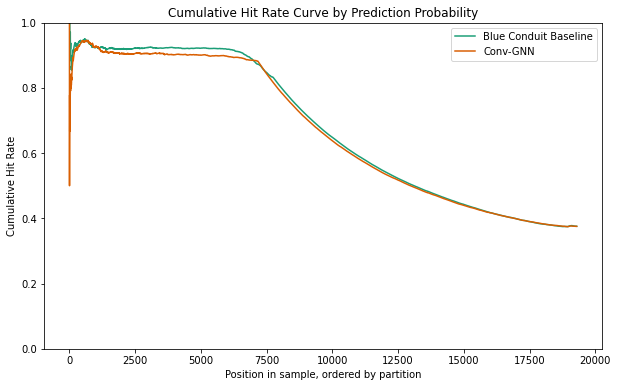

In [ ]:
y_pred = spatial_gnn.predict_proba(test_index)
mod_train_list = [test_pred, y_pred[:,1]]
# #plot_hit_rate_curve(Ytest, mod_train_list, labels=['XGBoost Baseline', 'GNN'], plot_probs=False)

threshold_orig = 0.9
threshold_increment_size = 0.1
N_lim = 5
N_lim_increment_size = 1

plot_hit_rate_curve(Ytest, mod_train_list, plot_probs=False, labels=['Blue Conduit Baseline', 'Conv-GNN'], mode='partition', 
                    parcel_df=hexagons.parcel_gdf, index_list=test_index, threshold_init=threshold_orig)


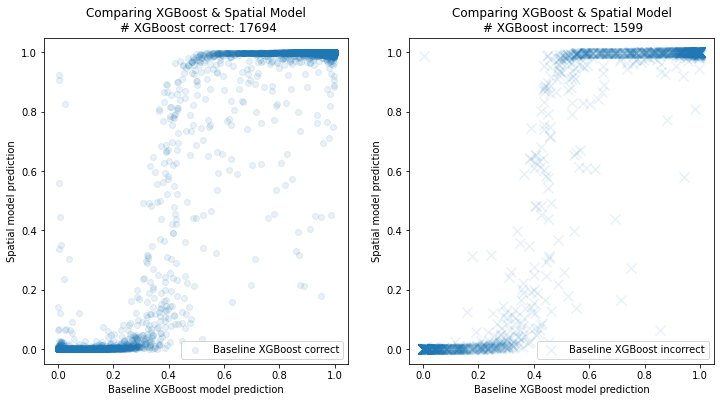

In [ ]:
def compare_pred_to_jared(y_pred):
    fig, axes = plt.subplots(1, 2, figsize=(12,6))

    jared_right_indices = np.array([i for i in range(len(Ytest)) if Ytest[i]==np.round(test_pred[i]).astype(int)])
    jared_wrong_indices = np.array([i for i in range(len(Ytest)) if Ytest[i]!=np.round(test_pred[i]).astype(int)])

    axes[0].scatter(test_pred[jared_right_indices], y_pred[jared_right_indices,1], marker='o', label='Baseline XGBoost correct', alpha=0.1)
    axes[1].scatter(test_pred[jared_wrong_indices], y_pred[jared_wrong_indices,1], marker='x', s=100, label='Baseline XGBoost incorrect', alpha=0.1)
    axes[0].set_xlabel('Baseline XGBoost model prediction')
    axes[0].set_ylabel('Spatial model prediction')
    axes[0].set_title(f'Comparing XGBoost & Spatial Model\n # XGBoost correct: {len(jared_right_indices)}')
    axes[1].set_xlabel('Baseline XGBoost model prediction')
    axes[1].set_ylabel('Spatial model prediction')
    axes[1].set_title(f'Comparing XGBoost & Spatial Model\n # XGBoost incorrect: {len(jared_wrong_indices)}')
    axes[0].legend()
    axes[1].legend()
    plt.show()
compare_pred_to_jared(y_pred)